# Exploratory data analysis

let's check that the data makes sense before proceding with calculations

#### imports

In [1]:
#add modelinter module to PYTHONPATH
#also import some things we'll use
%run imports.py

/home/orazio/.virtualenvs/model_interconnectedness_36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### load data

_Explanation_: we'll call two functions: `read_csvs()`, which reads the csv files with the raw data from disk, and `extract_arrays()`, which takes the data just read and extracts the numpy arrays we need to make the calculation.

If you want to read the code for these functions, just expand the two cells below.

In [2]:
from modelinter.preprocessing.imports_load_data import read_csvs, extract_arrays

In [3]:
view_code(read_csvs)

In file: ../../modelinter/preprocessing/imports_load_data.py


def read_csvs():
    timeseries = process_timeseries(Paths.FREE_DATA_DIR.value + 'timeseries.csv')
    timeseries_returns = process_timeseries_returns(Paths.FREE_DATA_DIR.value + 'timeseries_returns.csv')
    fed_sev_adverse = process_fed_sev_adverse(Paths.DATA_DIR.value + 'FedSeverelyAdverse.csv')
    longname = process_longnames(Paths.DATA_DIR.value + 'sp500_constituents.csv')
    return SimpleNamespace(
        timeseries=timeseries,
        timeseries_returns=timeseries_returns,
        fed_sev_adverse=fed_sev_adverse,
        longname=longname
    )



In [4]:
view_code(extract_arrays)

In file: ../../modelinter/preprocessing/imports_load_data.py


def extract_arrays(raw_data):
    # extract numpy arrays
    # slice for last year before CCAR + SIGMA_WINDOW
    firstday = (raw_data.fed_sev_adverse.index[0]
                - pd.Timedelta(Const.WHOLE_YEAR.value, 'd')
                - pd.Timedelta(Const.SIGMA_WINDOW.value, 'd'))
    all_time = slice(firstday,
                     raw_data.fed_sev_adverse.index[0])
    # slice foractual time - only last year and not the first month we need for the volatility
    time = slice(-Const.TRADING_YEAR.value, None)
    # stocks returns
    stocks_r = raw_data.timeseries_returns.loc[all_time, :].iloc[:, Slices.stocks_subset].values
    # stocks prices
    stocks_p = raw_data.timeseries.loc[all_time, :].iloc[:, Slices.stocks_subset].values
    # S&P500 returns
    sp_r = raw_data.timeseries_returns.loc[all_time, :].iloc[:, Slices.indices_subset][TimeseriesVariablesE.SP500.value].values
    # VIX, note that we scale it by 10 busines

In [5]:
raw_data = read_csvs()
arrays = extract_arrays(raw_data)

let's look at the  model connecting sp500 & stocks returns

the model is a linear regression like:

$r_{it} = \alpha_i + \beta_i I_t + \epsilon_{it} $

with:

* $r_{it}$ - returns of stock $i$ at time $t$
* $\alpha_i$ - zero order coefficient for stock $i$
* $\beta_i$ - first-order coefficient for stock $i$
* $\epsilon_{it}$ - residuals of the regression for stock $i$ at time $t$

### Check of the stock regressions

we'll do a regression of all the stocks against sp500 in a loop. the fucntion we use is `regression_loop`.

In [6]:
from modelinter.models.pgm import regression_loop

In [7]:
view_code(regression_loop)

In file: ../../modelinter/models/pgm.py


def regression_loop(index_returns, security_returns):
    beta, alpha, epsilon, r2 = [], [], [], []
    for j in range(security_returns.shape[1]):
        regression = lf(index_returns, security_returns[:, j])
        beta.append(regression[lf.m])
        alpha.append(regression[lf.q])
        # rsquared of the regression
        r2.append(regression[lf.r2])
        epsilon.append(regression[lf.obj].resid)
    return np.array(beta), np.array(alpha), np.array(epsilon), np.array(r2)



In [8]:
#regress stocks vs sp500, take in some statistics
beta, alpha, epsilon, r2 = regression_loop(arrays.sp_r, arrays.stocks_r)


In [9]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


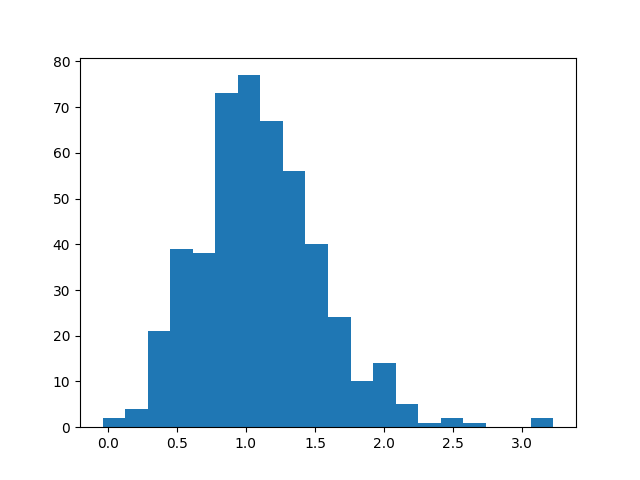

In [10]:
#distribution of betas
plt.hist(beta, bins = 20)
plt.show()

<IPython.core.display.Javascript object>


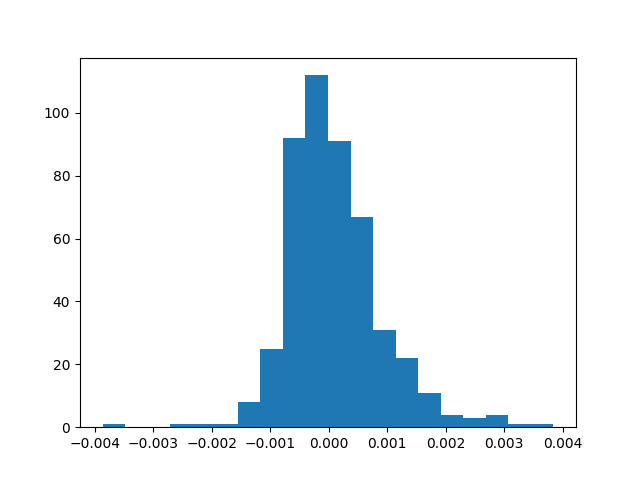

In [11]:
# distribution of alphas
plt.hist(alpha, bins = 20)
plt.show()

<IPython.core.display.Javascript object>


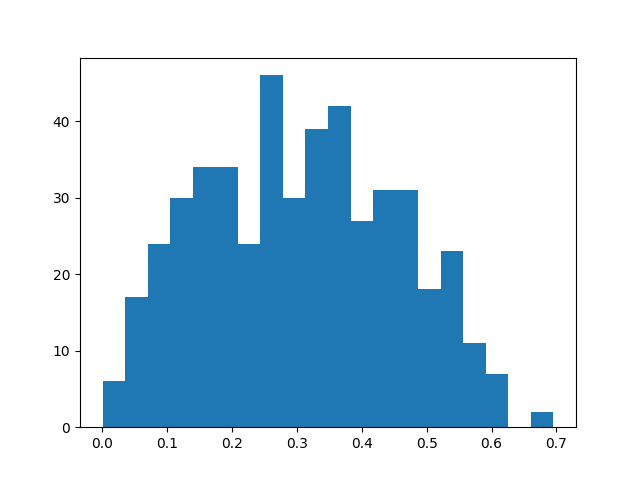

In [12]:
#distribution of rsquared
plt.hist(r2, bins = 20)
plt.show()

everything looks normal.

let's compare the distribution of residuals (across all stocks aggregated) with the  distribution of returns.

In [13]:
import numpy as np

<IPython.core.display.Javascript object>


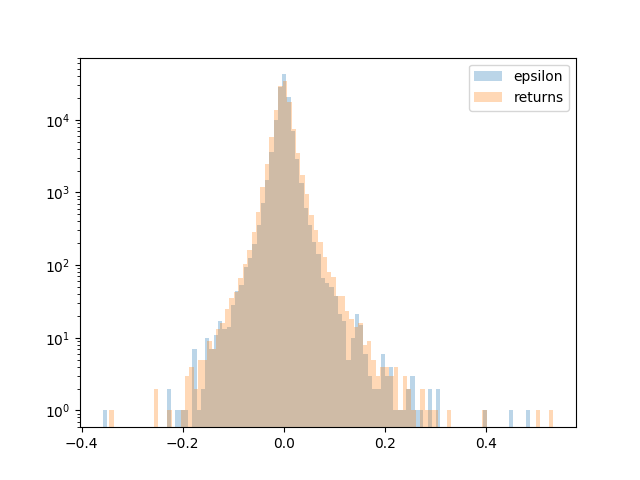

In [14]:
fig,ax = plt.subplots()
ax.hist(np.vstack(epsilon).flatten(), bins = 100, alpha = .3, log = True, label = 'epsilon')
ax.hist(arrays.stocks_r.flatten(), bins = 100, alpha = .3, log = True, label = 'returns')
ax.legend()

fig.show()

they are the same magnitude approximately.

let's compare, for each stock, beta with the standard deviation of its residuals.

<IPython.core.display.Javascript object>


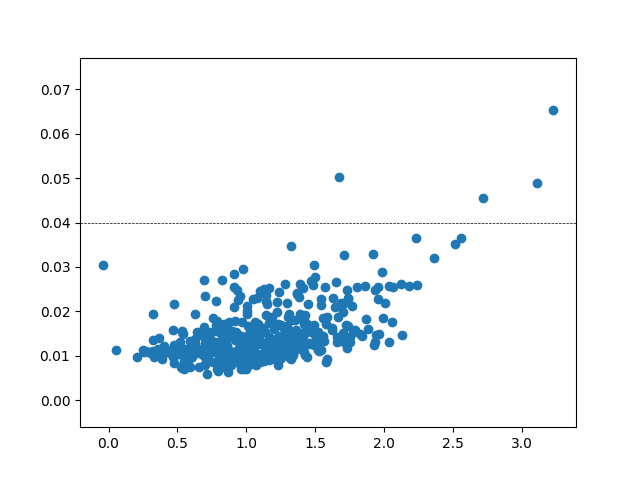

In [15]:
fig,ax = plt.subplots()
ax.scatter(beta, [np.std(_) for _ in epsilon])
ax.axhline(0.04, linestyle = 'dashed', linewidth = .5, color = 'k')
fig.show()

seems all right. rule of thumb, a lot of stocks with daily volatility >4% are indicators of unclean data with stock splits and the like. this data is supposed to be highly curated and with adjusted closes, so we don't expect this kind of problems.

Let's look at the stocks with top 5 standard deviation, to make sure.

In [18]:
import modelinter

In [19]:
#the csv in memory has two columns of indices
#and the rest of stocks data
#it's loaded into a pd.DataFrame in raw_data
#this is the slice to get the stocks only from it
stocks_subset = modelinter.models.constants.Slices.stocks_subset

In [20]:
stocksnames = raw_data.timeseries.iloc[:,stocks_subset].columns
top_std = list(reversed(sorted(zip([np.std(_) for _ in epsilon], stocksnames))))[:5]
top_std = [(_[0],_[1],raw_data.longname[_[1]]) for _ in top_std]
top_std

[(0.065274109737630148, 'CHK', 'Chesapeake Energy'),
 (0.050194564654219329, 'SWN', 'Southwestern Energy'),
 (0.049026859993586198, 'WMB', 'Williams Cos.'),
 (0.045598719082195135, 'FCX', 'Freeport-McMoRan Inc.'),
 (0.03658793126783335, 'RIG', 'Transocean')]

<IPython.core.display.Javascript object>


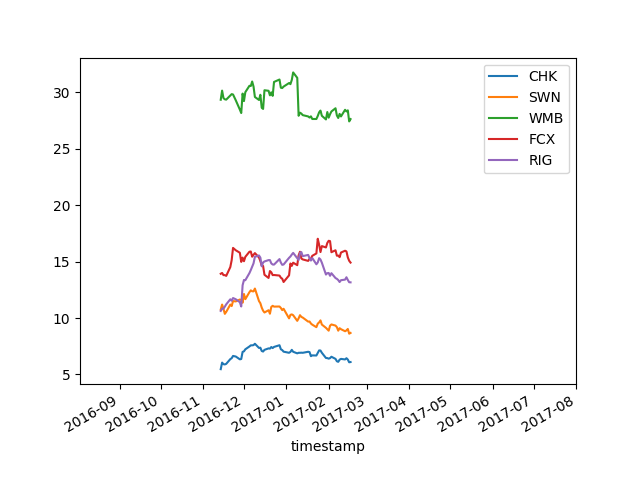

In [21]:
#note that for copyright reasons we had to delete
#most of the prices timeseries,
#so in this plot most of the entries are blank.
fig,ax = plt.subplots()
raw_data.timeseries.iloc[arrays.time,stocks_subset][[_[1] for _ in top_std]].plot(ax=ax)
fig.show()

<IPython.core.display.Javascript object>


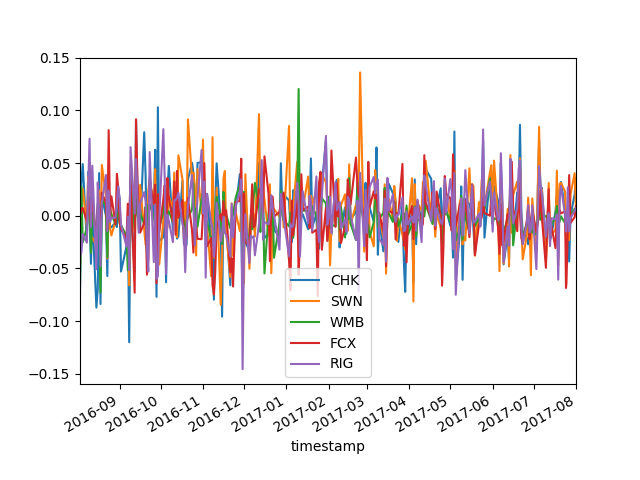

In [22]:
fig,ax = plt.subplots()
raw_data.timeseries_returns.iloc[arrays.time,stocks_subset][[_[1] for _ in top_std]].plot(ax=ax)
fig.show()

## GLASSO on the residuals
we're going to use the GLASSO algorithm to estimate the correct correlation matrix of the residuals. let's check that it works well.

Note that a very short documentation for GLASSO can be found [here](http://scikit-learn.org/stable/modules/covariance.html#sparse-inverse-covariance, "GLASSO documentation on scikit-learn.org"), otherwise we refer to the paper's bibliography for a more extensive explanation.

In [23]:
from sklearn.covariance import GraphLasso
from tqdm import tqdm

In [24]:
#make a np array with the residuals
epsilon_i = np.vstack(epsilon).T

In [25]:
#test that graph lasso works
model = GraphLasso(alpha = 0.01, mode = 'cd')
model.fit(epsilon_i)

GraphLasso(alpha=0.01, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

In [26]:
#now we'll check that the variance of the portfolio
#that we estimate with glasso decreases with alpha
#suppose the weights w are all equal
w = np.array([1/model.covariance_.shape[0]]*model.covariance_.shape[0])

In [ ]:
matrices = []
stds = []
#logspace contains the various alphas we'll try
logspace = np.logspace(-4, -1, num=10)
for alpha in tqdm(logspace):
    model = GraphLasso(alpha = alpha, mode = 'cd')
    model.fit(epsilon_i)
    matrices.append(model.covariance_)
    stds.append(np.sqrt(np.dot(np.matmul(w,model.covariance_),w)))
    
#let's add to the list what would happen with a penalty of ~0
#and let's put it at ~1e-8 on the plot we'll do next
stds = [np.sqrt(np.dot(np.matmul(w,np.cov(epsilon_i.T)),w))] + stds
logspace = [1e-8] + logspace.tolist()

<IPython.core.display.Javascript object>


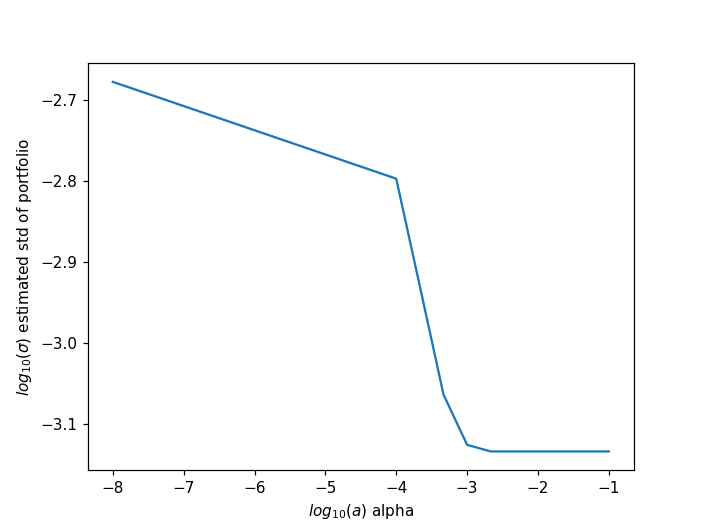

In [56]:
plt.plot(np.log10(logspace), np.log10(stds))
plt.xlabel('$ log_{10}( a ) $ alpha')
plt.ylabel('$ log_{10}( \sigma ) $ estimated std of portfolio')
plt.show()

## Volatility & VIX
Pricing options with black-scholes at time $t$ requires the implied volatiliy $\sigma_t$, or a measure of expected volatility at time $t$. We will model the implied volatility with a regression on VIX:

$\sigma_{it} = \eta_i + \theta_i J_t + \delta{it} $

where $J_t$ is the VIX index.

We won't use implied volatility $VI_t$ data directly to estimate the $\theta_i$ and parametrize the model. We will instead assume that realized future volatility $\sigma_{t+p}$ as a proxy for it, i.e. we assume:

$VI_t \propto \sigma_{t+p}$.

VIX is in fact related to implied volatility, but also realized volatility in the following month, as we're going to show.

We're going to see how much realized volatility of stock $\sigma_{i,t+p}$, i.e. delayed by $p$ days with respect to $t$, is correlated with VIX at time $t$, $VIX_{t}$ :

In [28]:
import pandas as pd

In [38]:
#note: the function that loads data
# i.e. modelinter.preprocessing.imports_load_data.extract_arrays()
#automatically applies the shift to the volatility
#we will have to undo it
shift = modelinter.models.constants.Const.SIGMA_SHIFT.value

In [45]:
#to delay easily, use the shift() method from Pandas
pdsigma = pd.DataFrame(arrays.sigma)
#undo the automatically applied shift
pdvix = pd.DataFrame(arrays.vix).shift(-shift)
delay = list(range(-70,70, 2))
delay = [_ for _ in delay if _]
result, result_err = [], []
#loop over possible delays
for p in tqdm(delay):
    cors = []
    #for every stock return timeseries r_j
    for j in range(arrays.stocks_r.shape[1]):
        #delay vix by p
        #it's faster
        x,y = pdvix.shift(p).values.flatten(), arrays.sigma[:,j].flatten()
        keep = np.isfinite(x) & np.isfinite(y)
        #calculate corr(vix_{t+p},r_t)
        regression = np.corrcoef(x[keep],y[keep])[0,1]
        cors.append(regression)
    #save statistics about the correlations
    result.append(np.mean(cors))
    result_err.append(np.std(cors))
    

100%|██████████| 69/69 [00:08<00:00,  7.95it/s]


the highest average correlation is found when we delay $\sigma$ by ~10 days!

In [46]:
wheremax = -delay[np.argmax(result)]
wheremax

-12

<IPython.core.display.Javascript object>


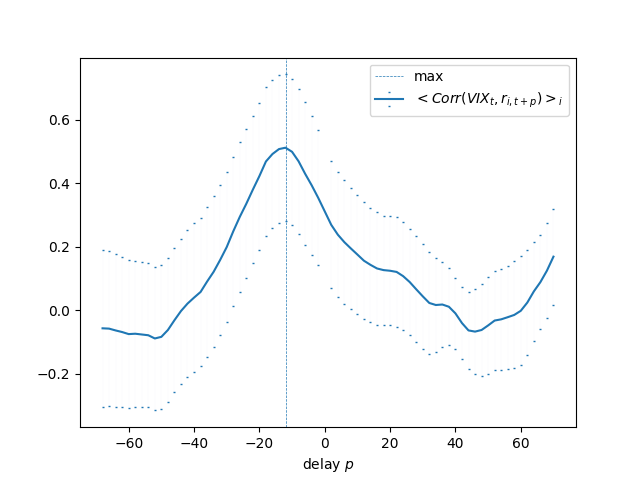

In [47]:
fig, ax = plt.subplots()
#corr(vix_{t+p},r_t) is equivalent to corr(vix_t,r_{t-p}) !
#so we'll invert p to get corr(vix_t,r_{t+p})
ax.errorbar(x=-np.array(delay), y=result, yerr=result_err, barsabove=True, elinewidth = .01, capsize = 1, capthick=1, label = '$<Corr(VIX_{t},r_{i,t+p})>_i$')
ax.axvline(wheremax, label='max', linewidth = .5, linestyle='dashed')
ax.legend(loc='best')
ax.set_xlabel('delay $p$')
#ax.set_ylabel('$<Corr(VIX_{t},r_{i,t+p})>_i$')
fig.show()

so let's look at the relation between volatility and VIX.

We will model the volatility $\sigma$ with a linear regression on the VIX index similar to the one for the stocks:

$\sigma_{it} = \eta_i + \theta_i J_t + \delta{it} $

where $J_t$ is the VIX index.

In [48]:
#let's look at how the regression is behaved.
#we'll regress all realized delayed standard deviations
#against VIX
theta_i, eta_i, delta_it, rsquared = regression_loop(arrays.vix, arrays.sigma)

<IPython.core.display.Javascript object>


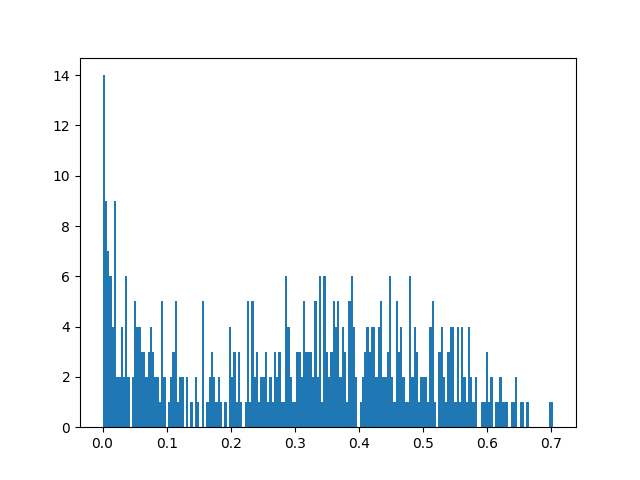

In [49]:
#R^2 distribution looks all right
fig,ax = plt.subplots()
ax.hist(rsquared.flatten(), bins= 200)
fig.show()

<IPython.core.display.Javascript object>


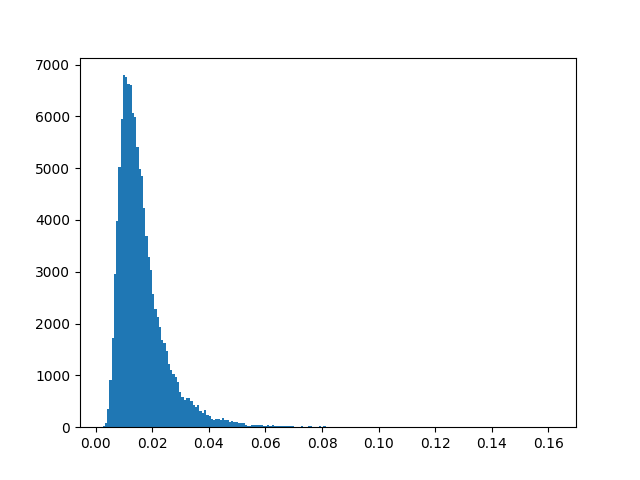

In [55]:
#this is the distribution of values for realized volatility
fig,ax = plt.subplots()
histogram_me = arrays.sigma.flatten()
histogram_me = histogram_me[np.isfinite(histogram_me)]
ax.hist(histogram_me, bins= 200)
fig.show()

<IPython.core.display.Javascript object>


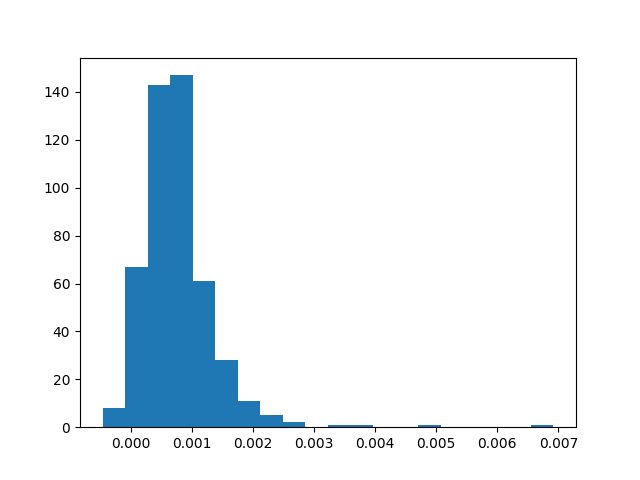

In [56]:
#first order coefficients look reasonable
#(keep in mind that log10(VIX) is between 1 and 2)
fig,ax = plt.subplots()
ax.hist(theta_i, bins= 20)
fig.show()

<IPython.core.display.Javascript object>


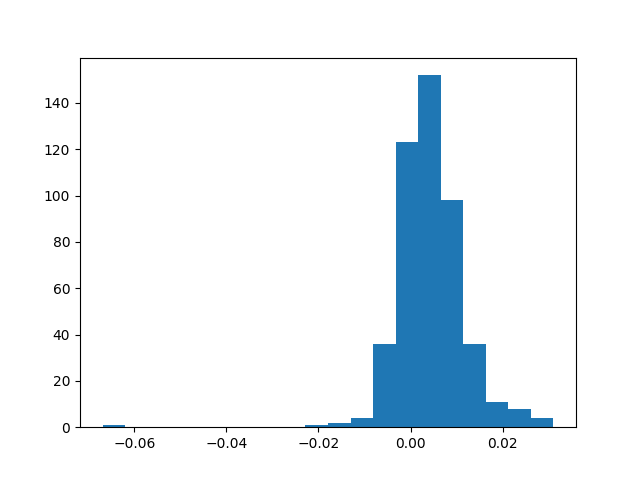

In [57]:
#notice how the 1st order coefficients are in general not negligible
fig,ax = plt.subplots()
ax.hist(eta_i, bins= 20)
fig.show()

<IPython.core.display.Javascript object>


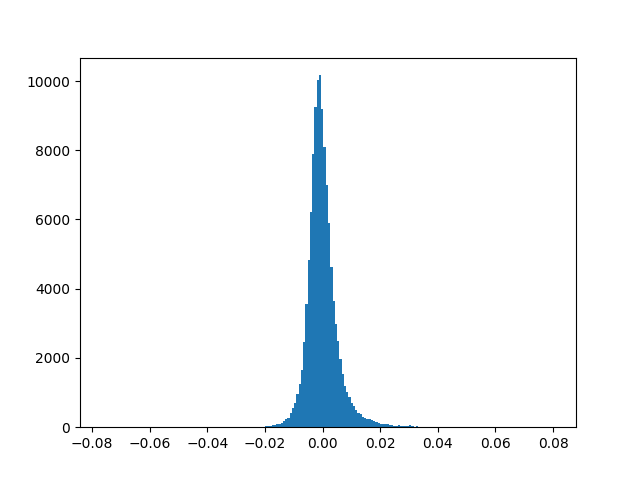

In [58]:
#and the residuals look well-behaved as well
#except they are distributed asymmetrically
fig,ax = plt.subplots()
ax.hist(np.array(delta_it).flatten(), bins= 200)
fig.show()

note that the first order coefficient $\eta_i$ in the model for volatility is not negligible!

<IPython.core.display.Javascript object>


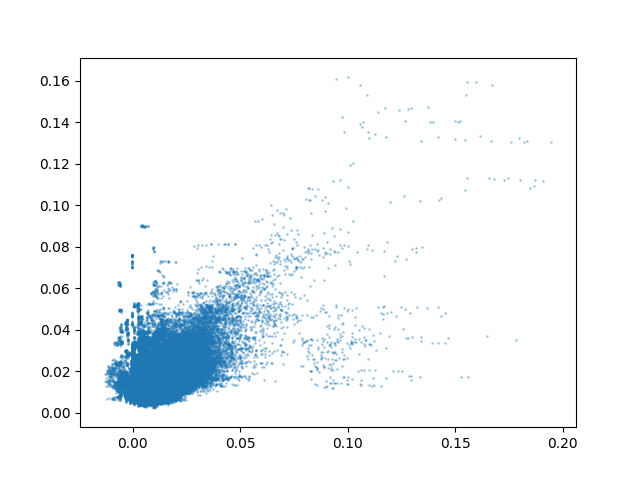

In [59]:
#without eta_i
sigma_reg = np.outer(arrays.vix,theta_i)
fig,ax = plt.subplots()
ax.scatter(sigma_reg.flatten(), arrays.sigma.flatten(), s= 1, alpha = .3)
fig.show()

In [61]:
#this function does a linear fit and plots it automatically
from modelinter.models.utils import linfitplot

<IPython.core.display.Javascript object>


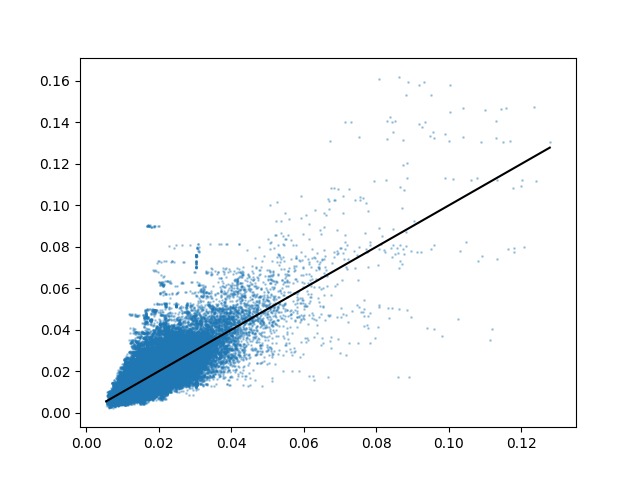

{'R^2': 0.62613282959869854,
 'df': 119952,
 'm': 0.999999999999999,
 'obj': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fb5685867f0>,
 'pval m': 0.0,
 'pval q': 0.99999999999990252,
 'q': 5.0076587841674236e-18,
 'stderr m': 0.0022581776608076452,
 'stderr q': 4.0963954892232411e-05,
 'stderr y': 3.307337047077795e-05}

In [62]:
#with eta_i
sigma_reg = eta_i + np.outer(arrays.vix,theta_i)
fig,ax = plt.subplots()
ax.scatter(sigma_reg.flatten(), arrays.sigma.flatten(), s= 1, alpha = .3)
reg = linfitplot(ax=ax, X=sigma_reg.flatten(), Y=arrays.sigma.flatten())
fig.show()
reg